Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
The Drug Design Data Resource (D3R) aims to advance the technology of computer-aided drug discovery through the interchange of high quality protein-ligand datasets and workflows, and by holding community-wide, blinded prediction challenges. The D3R project is based at the University of California San Diego (UCSD), where it is co-directed by Drs. Rommie Amaro and Michael Gilson. An additional D3R component, focused on determining, validating and archiving protein-ligand co-crystal structures, is hosted at Rutgers the State University of New Jersey and led by Dr. Stephen K. Burley, who is Director of the RCSB Protein Data Bank.

## Assay Information
The cathepsins constitute an 11-member family of proteases involved in protein degradation. Cathepsin S is highly expressed in antigen-presenting cells, where it degrades major histocompatibility complex class II (MHC II)-associated invariant chain. CatS is a candidate target for regulating immune hyper-responsiveness, as the inhibition of CatS may limit antigen presentation. This data set comprises a follow-on challenge to GC3, consisting of non-peptidic, non-covalent, small molecule inhibitors across a three order of magnitude range (nM to μM) of IC50s for CatS. Specifically, we provide 459 CatS inhibitors for affinity prediction. This dataset was kindly donated by Janssen. Please note the affinity values from this set were measured against a C25S CatS mutant.


## Description of readout:
- **AFFINITY**: Affinity of molecules for a C25S Cathepsin S mutant. 

## Data resource

**Raw data**: https://drugdesigndata.org/about/datasets/2028

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd

import datamol as dm

from polaris import curation
from polaris.curation.viz_utils import (
    visualize_distribution,
    detailed_distributions_plots,
    verify_stereoisomers,
    visualize_chemspace,
)
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.utils.types import HubOwner

import tempfile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset was downloaded directly from [D3R](https://drugdesigndata.org/about/datasets) on 2024-03-22 by following the link under Name. We saved a version of the raw data as a parquet file in a Google Cloud bucket.

In [4]:
# Load the dataset
data = pd.read_parquet(
    "gs://polaris-public/data/raw/D3R/D3R_CatS_GC4_raw.parquet"
)  # affinity prediction

Keep only the SMILES and Affinity rows

In [5]:
# Keep only the SMILES, ID and outcome rows
columns_to_keep = ["Cmpd_ID", "SMILES", "Affinity"]
data = data[columns_to_keep].copy()
# Rename all columns to uppercase
for col in data.columns:
    data.rename(columns={col: col.upper()}, inplace=True)

In [6]:
# Define data column names
endpoints = [
    "AFFINITY",
]
data_cols = endpoints
mol_col = "SMILES"

### Run preliminary curation for data inspection

In [7]:
# preliminary curation for data inspection
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    keep_all_rows=True,
)
data_look = curator()

2024-04-15 14:57:38.047 | WARNING  | polaris.curation._data_curator:run_data_curation:233 - Data types are not provides. We will try our best to determine the types
2024-04-15 14:57:38.049 | WARNING  | polaris.curation._data_curator:check_outliers:201 - Detected 9 outliers for data column AFFINITY using zscore. Please revise the data and consider remove the outliers. 
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


The curator has detected outliers. Let's have a look at them.

[<Figure size 1600x400 with 2 Axes>]

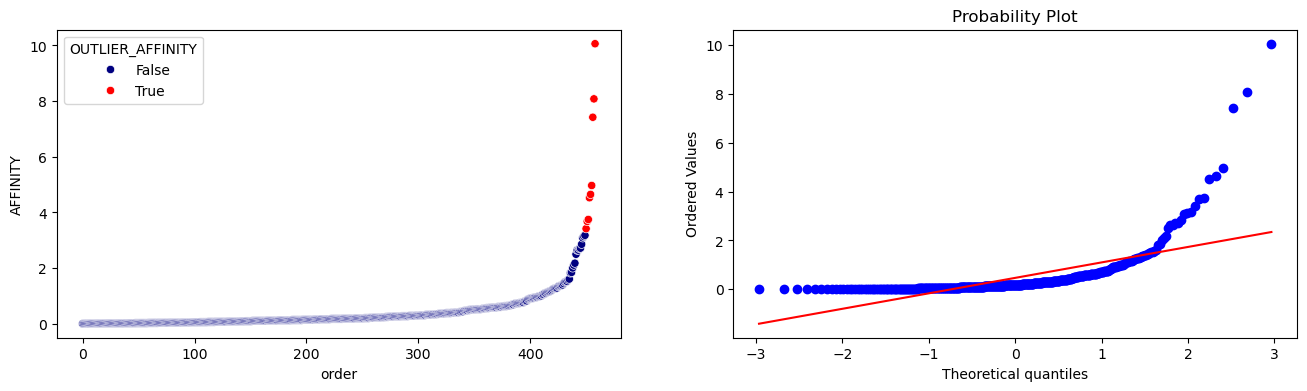

In [8]:
visualize_distribution(dataset=data_look, data_cols=data_cols)

The flagged outliers are likely false outliers as they are located on the end of the data distribution.

### Re-run curation, removing molecules as needed

In [9]:
### Re-run the curation steps, this time removing molecules with undefined stereoisomers and removing duplicates
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    # remove molecules which has undefined stereocenter and also show activity shift to the sterepisomers
    mask_stereo_undefined_mols=False,
    # remove all the molecule rows including the duplicates
    keep_all_rows=False,
)
data_curated = curator_with_stereo()

2024-04-15 14:57:38.997 | WARNING  | polaris.curation._data_curator:run_data_curation:233 - Data types are not provides. We will try our best to determine the types
2024-04-15 14:57:38.999 | WARNING  | polaris.curation._data_curator:check_outliers:201 - Detected 9 outliers for data column AFFINITY using zscore. Please revise the data and consider remove the outliers. 
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


In [10]:
print(data.shape)
print(data_curated.shape)
data_curated

(459, 3)
(459, 18)


,CMPD_ID,SMILES,AFFINITY,ORIGINAL_AFFINITY,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_AFFINITY,AFFINITY_zscore,AFFINITY_stereo_cliff
0,CatS_32,CC(C)(C)OC(=O)N1CCC(CC1)NCCSc2cc(ccc2C(F)(F)F)...,2.180,2.180,CC(C)(C)OC(=O)N1CCC(CC1)NCCSc2cc(ccc2C(F)(F)F)...,CC(C)(C)OC(=O)N1CCC(NCCSc2cc(-c3nn(CCCN4CCCCC4...,006ca187b5a50386918604f83fa8ae11eeeca4bf,a70282af55457a5ad3cf0d93a7d4698be61c2279,0,0,0,1,1,False,True,False,9.846580,NaN
1,CatS_95,c1ccnc(c1)C2CCN(CC2)C[C@@H](Cn3c4c(c(n3)c5ccc(...,0.170,0.170,c1ccnc(c1)C2CCN(CC2)C[C@@H](Cn3c4c(c(n3)c5ccc(...,O[C@@H](CN1CCC(c2ccccn2)CC1)Cn1nc(-c2ccc(C(F)(...,006dba3818b8748d637292ad3032b009ddf66959,40e41c4039d2e9f15f7959297df56c7263a8f0de,1,0,1,2,1,False,False,False,-0.049233,NaN
2,CatS_107,c1cc(c(cc1c2c3c(n(n2)C[C@H](CN4CCC(CC4)NC(=O)C...,1.360,1.360,c1cc(c(cc1c2c3c(n(n2)C[C@H](CN4CCC(CC4)NC(=O)C...,O=C(CO)NC1CCN(C[C@H](O)Cn2nc(-c3ccc(C(F)(F)F)c...,01020eefc67cd5c6227c91712a0863370dd7b59f,a09873e8ce54a0768b25fa913602f859ebb7ec05,1,0,1,2,1,False,False,False,5.809482,NaN
3,CatS_453,CNCCCNC(=O)c1ccc(cc1)C#Cc2cc(ccc2Cl)c3c4c(n(n3...,0.075,0.075,CNCCCNC(=O)c1ccc(cc1)C#Cc2cc(ccc2Cl)c3c4c(n(n3...,CNCCCNC(=O)c1ccc(C#Cc2cc(-c3nn(CCCN4CCSCC4)c4c...,01c4e98340a0414b6730602a733ab1e564164996,9a5647211a085e7e7ad08d30bd6bac454534e8b9,0,0,0,1,1,False,True,False,-0.516945,NaN
4,CatS_303,CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCOCC3)c4ccc(c(c4)...,0.130,0.130,CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCOCC3)c4ccc(c(c4)...,CS(=O)(=O)N1CCc2c(c(-c3ccc(Cl)c(C#Cc4ccc5c(c4)...,026e8d83077a6661ad58edb0c13a0990a676d90a,3a6c15b3dc1ef832ce7ee1e1a8bbc179b84ed386,1,0,1,2,1,False,False,False,-0.246165,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
454,CatS_300,c1cc(ccc1CNCc2ccc(cc2)Cl)C#Cc3cc(ccc3Cl)c4c5c(...,0.110,0.110,c1cc(ccc1CNCc2ccc(cc2)Cl)C#Cc3cc(ccc3Cl)c4c5c(...,NC(=O)N1CCc2c(c(-c3ccc(Cl)c(C#Cc4ccc(CNCc5ccc(...,fb40e1ed136d5d79d111ac7857e7951dba4f0b27,8c5fa254e50c4314e0d6b2bd2105ab286b3415c8,0,0,0,1,1,False,True,False,-0.344630,NaN
455,CatS_231,CS(=O)(=O)N1CCc2c(c(nn2C[C@H](CN3CCC(CC3)C4CCC...,0.065,0.065,CS(=O)(=O)N1CCc2c(c(nn2C[C@H](CN3CCC(CC3)C4CCC...,CS(=O)(=O)N1CCc2c(c(-c3ccc(C(F)(F)F)c(SCCN4CC[...,fd22ca8183270df5f525ba30dab438c7ac1135d7,8c5c29ddf5e35962a960dbce707f0012e9809c11,2,0,2,4,1,False,False,False,-0.566178,NaN
456,CatS_12,CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCC(CC3)C(F)(F)F)c...,0.230,0.230,CS(=O)(=O)N1CCc2c(c(nn2CCCN3CCC(CC3)C(F)(F)F)c...,CS(=O)(=O)N1CCc2c(c(-c3ccc(C(F)(F)F)c(SCC(=O)N...,fe4453d12f590d24f657b9135bec9b755be737f1,63821d8f577e0dde54da75bed043eead221cb0d1,0,0,0,1,1,False,True,False,0.246165,NaN
457,CatS_6,COC1CCN(CC1)CCSc2cc(ccc2C(F)(F)F)c3c4c(n(n3)CC...,0.270,0.270,COC1CCN(CC1)CCSc2cc(ccc2C(F)(F)F)c3c4c(n(n3)CC...,COC1CCN(CCSc2cc(-c3nn(CCCN4CCC(N5CCCC5=O)CC4)c...,ff49976b5e53cd572ec2b428ac3ef61d63dbed8e,b149bcf17935fc1e9825873b77d89492a902b131,0,0,0,1,1,False,True,False,0.443096,NaN


Let's remove those samples with stereoisomer cliffs.

In [12]:
# Additional meta-data on the column level
annotations = {
    "smiles": ColumnAnnotation(
        description="Molecule SMILES string", modality="molecule"
    ),
    "AFFINITY": ColumnAnnotation(
        description="Affinity against a C25S Cathepsin S mutant."
    ),
}

In [13]:
dataset = Dataset(
    # The table is the core data-structure required to construct a dataset
    table=data_curated,
    # Additional meta-data on the dataset level.
    name="D3R_Cathepsin_S_C25S_Affinity",
    description="Drug Design Data Resource Grand Challenge 4 Dataset: CathepsinS",
    source="https://drugdesigndata.org/about/datasets/2028",
    annotations=annotations,
    tags=["Affinity"],
    owner=HubOwner(user_id="Polaris", slug="polaris"),
    license="CC-BY-SA-4.0",
    user_attributes={"year": "2020"},
    curation_reference="https://github.com/polaris-hub/polaris-recipes/05_D3R/05_01_D3R_Cathepsin_C25S_data_curation.ipynb",
)

In [14]:
# Make a temporary directory to save the dataset
temp_dir = tempfile.TemporaryDirectory().name

save_dir = dm.fs.join(temp_dir, "dataset")

path = dataset.to_json(save_dir)

# Look at the save destination
fs = dm.fs.get_mapper(save_dir).fs
fs.ls(save_dir)

['/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmpj43lkzr5/dataset/table.parquet',
 '/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/tmpj43lkzr5/dataset/dataset.json']

In [15]:
folder = "05_D3R"
data_curated.to_parquet(
    f"gs://polaris-private/curated_datasets/{folder}/{dataset.name}_curated.parquet"
)  # Save just in case. Requires a data folder.

save_dir = f"gs://polaris-private/Datasets/{folder}/{dataset.name}"
dataset.to_json(save_dir)

save_dir = f"gs://polaris-public/Datasets/{folder}/{dataset.name}"
dataset.to_json(save_dir)

# dataset.upload_to_hub()

/Users/lu.zhu/miniconda3/envs/polaris_datasets/lib/python3.12/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `url` but got `str` - serialized value may not be as expected
  Expected `url` but got `str` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


'gs://polaris-public/Datasets/05_D3R/D3R_Cathepsin_S_C25S_Affinity/dataset.json'